In [15]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
from dataclasses import dataclass, field
from abc import ABC, abstractmethod
import sys
sys.path.append("/home/armand/PhD/oc-guidance/models")
sys.path.append("/home/armand/PhD/oc-guidance/")
from guided_diffusion import create_model, create_model_and_diffusion, model_and_diffusion_defaults
from utils.degredations import build_degredation_model
from utils.functions import sigmoid, get_timesteps
# load and show test_image.png
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as T
from math import prod
from tqdm.auto import tqdm, trange
from torch.utils.data import DataLoader
from fff import FiberModel
from tqdm.auto import tqdm
import argparse
import json
import tempfile
import random

import monai
from monai.apps import download_url
from monai.config import print_config
from monai.transforms import LoadImage, Orientation
from monai.utils import set_determinism
from monai.inferers.inferer import SlidingWindowInferer
from monai.networks.schedulers import RFlowScheduler
from monai.data import MetaTensor

from monai_utils.sample import LDMSampler, ReconModel, check_input, ldm_conditional_sample_one_mask, filter_mask_with_organs
from monai_utils.utils import define_instance, dynamic_infer, binarize_labels
from monai_utils.utils_plot import find_label_center_loc, get_xyz_plot, show_image
from monai_utils.diff_model_setting import setup_logging
from monai_utils.find_masks import find_masks
from monai_utils.augmentation import augmentation

device = "cuda" if torch.cuda.is_available() else "cpu"

# Code from the inference tutorial

In [2]:
model_def_path = "./configs/config_maisi3d-rflow.json"
with open(model_def_path, "r") as f:
    model_def = json.load(f)

In [3]:
os.environ["MONAI_DATA_DIRECTORY"] = "."
directory = os.environ.get("MONAI_DATA_DIRECTORY")
if directory is not None:
    os.makedirs(directory, exist_ok=True)
root_dir = tempfile.mkdtemp() if directory is None else directory

In [4]:
files = [
    {
        "path": "models/autoencoder_epoch273.pt",
        "url": "https://developer.download.nvidia.com/assets/Clara/monai/tutorials"
        "/model_zoo/model_maisi_autoencoder_epoch273_alternative.pt",
    },
    {
        "path": "models/mask_generation_autoencoder.pt",
        "url": "https://developer.download.nvidia.com/assets/Clara/monai" "/tutorials/mask_generation_autoencoder.pt",
    },
    {
        "path": "models/mask_generation_diffusion_unet.pt",
        "url": "https://developer.download.nvidia.com/assets/Clara/monai"
        "/tutorials/model_zoo/model_maisi_mask_generation_diffusion_unet_v2.pt",
    },
    {
        "path": "configs/all_anatomy_size_condtions.json",
        "url": "https://developer.download.nvidia.com/assets/Clara/monai/tutorials/all_anatomy_size_condtions.json",
    },
    {
        "path": "datasets/all_masks_flexible_size_and_spacing_4000.zip",
        "url": "https://developer.download.nvidia.com/assets/Clara/monai"
        "/tutorials/all_masks_flexible_size_and_spacing_4000.zip",
    },
    {
        "path": "models/diff_unet_3d_rflow.pt",
        "url": "https://developer.download.nvidia.com/assets/Clara/monai/tutorials/"
        "diff_unet_ckpt_rflow_epoch19350.pt",
    },
    {
        "path": "models/controlnet_3d_rflow.pt",
        "url": "https://developer.download.nvidia.com/assets/Clara/monai/tutorials/controlnet_rflow_epoch60.pt",
    },
    {
        "path": "configs/candidate_masks_flexible_size_and_spacing_4000.json",
        "url": "https://developer.download.nvidia.com/assets/Clara/monai"
        "/tutorials/candidate_masks_flexible_size_and_spacing_4000.json",
    },
]

for file in files:
    file["path"] = file["path"] if "datasets/" not in file["path"] else os.path.join(root_dir, file["path"])
    download_url(url=file["url"], filepath=file["path"])


2025-08-12 18:53:17,517 - INFO - Expected md5 is None, skip md5 check for file models/autoencoder_epoch273.pt.
2025-08-12 18:53:17,518 - INFO - File exists: models/autoencoder_epoch273.pt, skipped downloading.
2025-08-12 18:53:17,518 - INFO - Expected md5 is None, skip md5 check for file models/mask_generation_autoencoder.pt.
2025-08-12 18:53:17,518 - INFO - File exists: models/mask_generation_autoencoder.pt, skipped downloading.
2025-08-12 18:53:17,519 - INFO - Expected md5 is None, skip md5 check for file models/mask_generation_diffusion_unet.pt.
2025-08-12 18:53:17,519 - INFO - File exists: models/mask_generation_diffusion_unet.pt, skipped downloading.
2025-08-12 18:53:17,519 - INFO - Expected md5 is None, skip md5 check for file configs/all_anatomy_size_condtions.json.
2025-08-12 18:53:17,520 - INFO - File exists: configs/all_anatomy_size_condtions.json, skipped downloading.
2025-08-12 18:53:17,520 - INFO - Expected md5 is None, skip md5 check for file datasets/all_masks_flexible_s

In [5]:
args = argparse.Namespace()

environment_file = "./configs/environment_maisi3d-rflow.json"

with open(environment_file, "r") as f:
    env_dict = json.load(f)
for k, v in env_dict.items():
    # Update the path to the downloaded dataset in MONAI_DATA_DIRECTORY
    val = v if "datasets/" not in v else os.path.join(root_dir, v)
    setattr(args, k, val)
    print(f"{k}: {val}")
print("Global config variables have been loaded.")

output_dir: output
trained_autoencoder_path: models/autoencoder_epoch273.pt
trained_diffusion_path: models/diff_unet_3d_rflow.pt
trained_controlnet_path: models/controlnet_3d_rflow.pt
trained_mask_generation_autoencoder_path: models/mask_generation_autoencoder.pt
trained_mask_generation_diffusion_path: models/mask_generation_diffusion_unet.pt
all_mask_files_base_dir: ./datasets/all_masks_flexible_size_and_spacing_4000
all_mask_files_json: ./configs/candidate_masks_flexible_size_and_spacing_4000.json
all_anatomy_size_conditions_json: ./configs/all_anatomy_size_condtions.json
label_dict_json: ./configs/label_dict.json
label_dict_remap_json: ./configs/label_dict_124_to_132.json
Global config variables have been loaded.


In [6]:
with open(model_def_path, "r") as f:
    model_def = json.load(f)
for k, v in model_def.items():
    setattr(args, k, v)

# check the format of inference inputs
config_infer_file = "./configs/config_infer_8g_256x256x128.json"
with open(config_infer_file, "r") as f:
    config_infer_dict = json.load(f)
for k, v in config_infer_dict.items():
    setattr(args, k, v)
    print(f"{k}: {v}")

check_input(
    args.body_region,
    args.anatomy_list,
    args.label_dict_json,
    args.output_size,
    args.spacing,
    args.controllable_anatomy_size,
)
latent_shape = [args.latent_channels, args.output_size[0] // 4, args.output_size[1] // 4, args.output_size[2] // 4]
print("Network definition and inference inputs have been loaded.")

INFO: `controllable_anatomy_size` is empty.
We will synthesize based on `body_region`: (['chest']) and `anatomy_list`: (['lung tumor']).
INFO: The generate results will have voxel size to be [1.5, 1.5, 4.0]mm, volume size to be [256, 256, 128].


num_output_samples: 1
body_region: ['chest']
anatomy_list: ['lung tumor']
controllable_anatomy_size: []
num_inference_steps: 30
mask_generation_num_inference_steps: 1000
output_size: [256, 256, 128]
image_output_ext: .nii.gz
label_output_ext: .nii.gz
spacing: [1.5, 1.5, 4.0]
autoencoder_sliding_window_infer_size: [16, 16, 16]
autoencoder_sliding_window_infer_overlap: 0.6666
autoencoder_tp_num_splits: 12
controlnet: $@controlnet_def
diffusion_unet: $@diffusion_unet_def
autoencoder: $@autoencoder_def
mask_generation_autoencoder: $@mask_generation_autoencoder_def
mask_generation_diffusion: $@mask_generation_diffusion_def
modality: 1
Network definition and inference inputs have been loaded.


In [7]:
noise_scheduler = define_instance(args, "noise_scheduler")
mask_generation_noise_scheduler = define_instance(args, "mask_generation_noise_scheduler")

device = torch.device("cuda")

autoencoder = define_instance(args, "autoencoder_def").to(device)
checkpoint_autoencoder = torch.load(args.trained_autoencoder_path, weights_only=True)
autoencoder.load_state_dict(checkpoint_autoencoder)

diffusion_unet = define_instance(args, "diffusion_unet_def").to(device)
checkpoint_diffusion_unet = torch.load(args.trained_diffusion_path, weights_only=False)
diffusion_unet.load_state_dict(checkpoint_diffusion_unet["unet_state_dict"], strict=True)
scale_factor = checkpoint_diffusion_unet["scale_factor"].to(device)

controlnet = define_instance(args, "controlnet_def").to(device)
checkpoint_controlnet = torch.load(args.trained_controlnet_path, weights_only=False)
monai.networks.utils.copy_model_state(controlnet, diffusion_unet.state_dict())
controlnet.load_state_dict(checkpoint_controlnet["controlnet_state_dict"], strict=True)

mask_generation_autoencoder = define_instance(args, "mask_generation_autoencoder_def").to(device)
checkpoint_mask_generation_autoencoder = torch.load(args.trained_mask_generation_autoencoder_path, weights_only=True)
mask_generation_autoencoder.load_state_dict(checkpoint_mask_generation_autoencoder)

mask_generation_diffusion_unet = define_instance(args, "mask_generation_diffusion_def").to(device)
checkpoint_mask_generation_diffusion_unet = torch.load(args.trained_mask_generation_diffusion_path, weights_only=True)
mask_generation_diffusion_unet.load_state_dict(checkpoint_mask_generation_diffusion_unet["unet_state_dict"])
mask_generation_scale_factor = checkpoint_mask_generation_diffusion_unet["scale_factor"]

print("All the trained model weights have been loaded.")

2025-08-12 18:53:20,849 - INFO - 'dst' model updated: 180 of 231 variables.
All the trained model weights have been loaded.


In [8]:
set_determinism(seed=0)
args.random_seed = 0

In [9]:
ldm_sampler = LDMSampler(
    args.body_region,
    args.anatomy_list,
    args.all_mask_files_json,
    args.all_anatomy_size_conditions_json,
    args.all_mask_files_base_dir,
    args.label_dict_json,
    args.label_dict_remap_json,
    autoencoder,
    diffusion_unet,
    controlnet,
    noise_scheduler,
    scale_factor,
    mask_generation_autoencoder,
    mask_generation_diffusion_unet,
    mask_generation_scale_factor,
    mask_generation_noise_scheduler,
    device,
    latent_shape,
    args.mask_generation_latent_shape,
    args.output_size,
    args.output_dir,
    args.controllable_anatomy_size,
    image_output_ext=args.image_output_ext,
    label_output_ext=args.label_output_ext,
    spacing=args.spacing,
    modality=args.modality,
    num_inference_steps=args.num_inference_steps,
    mask_generation_num_inference_steps=args.mask_generation_num_inference_steps,
    random_seed=args.random_seed,
    autoencoder_sliding_window_infer_size=args.autoencoder_sliding_window_infer_size,
    autoencoder_sliding_window_infer_overlap=args.autoencoder_sliding_window_infer_overlap,
)

INFO: LDM sampler initialized.


In [10]:
with torch.no_grad():
    output_filenames = ldm_sampler.sample_multiple_images(args.num_output_samples)

augmenting lung tumor
30
metatensor(7854., device='cuda:0') | metatensor(7704.4004, device='cuda:0')


100%|███████████████████████████████████████████████████████████████| 605/605 [00:58<00:00, 10.28it/s]


1 5
augmenting lung tumor
28
metatensor(1016., device='cuda:0') | metatensor(1327.7001, device='cuda:0')
metatensor(728., device='cuda:0') | metatensor(1327.7001, device='cuda:0')
metatensor(1035., device='cuda:0') | metatensor(1327.7001, device='cuda:0')
metatensor(626., device='cuda:0') | metatensor(1327.7001, device='cuda:0')
metatensor(0., device='cuda:0') | metatensor(1327.7001, device='cuda:0')
metatensor(150., device='cuda:0') | metatensor(1327.7001, device='cuda:0')
metatensor(1081., device='cuda:0') | metatensor(1327.7001, device='cuda:0')
metatensor(1113., device='cuda:0') | metatensor(1327.7001, device='cuda:0')
metatensor(0., device='cuda:0') | metatensor(1327.7001, device='cuda:0')
metatensor(0., device='cuda:0') | metatensor(1327.7001, device='cuda:0')
metatensor(1815., device='cuda:0') | metatensor(1327.7001, device='cuda:0')


100%|███████████████████████████████████████████████████████████████| 605/605 [01:00<00:00, 10.02it/s]


1 4
2025-08-12 10:53:17,543 INFO image_writer.py:197 - writing: output/sample_20250812_105317_532910_image.nii.gz
2025-08-12 10:53:18,079 INFO image_writer.py:197 - writing: output/sample_20250812_105317_532910_label.nii.gz


Visualizing output/sample_20250812_105317_532910_image.nii.gz and output/sample_20250812_105317_532910_label.nii.gz...


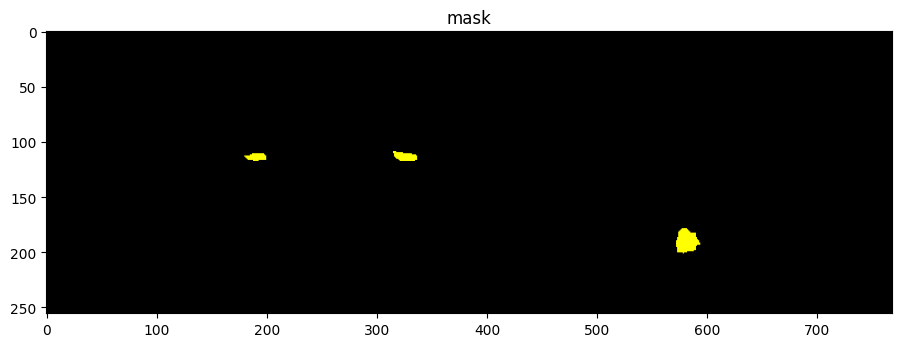

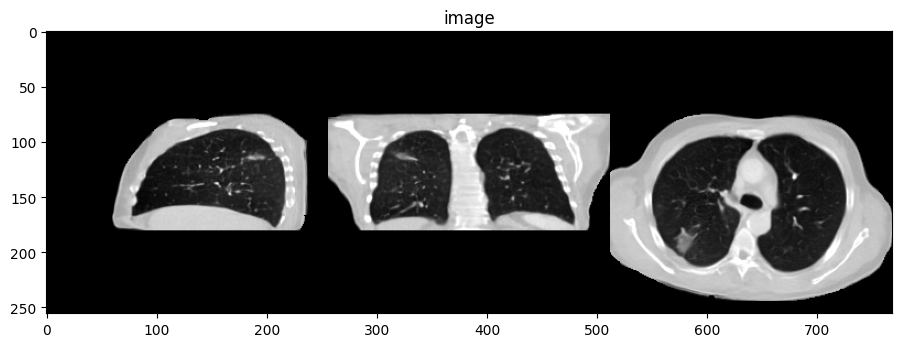

In [12]:
visualize_image_filename = output_filenames[0][0]
visualize_mask_filename = output_filenames[0][1]
print(f"Visualizing {visualize_image_filename} and {visualize_mask_filename}...")

# load image/mask pairs
loader = LoadImage(image_only=True, ensure_channel_first=True)
orientation = Orientation(axcodes="RAS")
image_volume = orientation(loader(visualize_image_filename))
mask_volume = orientation(loader(visualize_mask_filename)).to(torch.uint8)

# visualize for CT HU intensity between [-200, 500]
image_volume = torch.clip(image_volume, -1000, 300)
image_volume = image_volume - torch.min(image_volume)
image_volume = image_volume / torch.max(image_volume)

# create a random color map for mask visualization
colorize = torch.clip(torch.cat([torch.zeros(3, 1, 1, 1), torch.randn(3, 200, 1, 1)], 1), 0, 1)
target_class_index = 1

# find center voxel location for 2D slice visualization
center_loc_axis = find_label_center_loc(torch.flip(mask_volume[0, ...] == target_class_index, [-3, -2, -1]))

# visualization
vis_mask = get_xyz_plot(
    mask_volume, center_loc_axis, mask_bool=True, n_label=201, colorize=colorize, target_class_index=target_class_index
)
show_image(vis_mask, title="mask")

vis_image = get_xyz_plot(image_volume, center_loc_axis, mask_bool=False)
show_image(vis_image, title="image")

# NDTM Integration

In [2]:
class FlowMatchingModel:
    def __init__(self, ldm_sampler):
        self.ldm_sampler = ldm_sampler
        self.recon_model = ReconModel(ldm_sampler.autoencoder, ldm_sampler.scale_factor)
        self.inferer = SlidingWindowInferer(
            roi_size=ldm_sampler.autoencoder_sliding_window_infer_size,
            sw_batch_size=1,
            progress=True,
            mode="gaussian",
            overlap=ldm_sampler.autoencoder_sliding_window_infer_overlap,
            sw_device=device,
            device=torch.device("cpu"),
        )
        self.include_modality = ldm_sampler.diffusion_unet.num_class_embeds is not None
        self.include_body_region = ldm_sampler.diffusion_unet.include_top_region_index_input

    def get_label_tensor(self, **kwargs):
        combine_label_tensor = kwargs.get('combine_label_tensor', None)
        if combine_label_tensor is not None:
            combine_label = combine_label_tensor.to(device)
            if (
                self.ldm_sampler.output_size[0] != combine_label.shape[2]
                or self.ldm_sampler.output_size[1] != combine_label.shape[3]
                or self.ldm_sampler.output_size[2] != combine_label.shape[4]
            ):
                combine_label = torch.nn.functional.interpolate(combine_label, size=self.ldm_sampler.output_size, mode="nearest")
            
            return combine_label
        else:
            return None
    
    
    def __call__(self, xt, y, t, **kwargs):
        """
        Forward pass through the flow matching model.
        :param xt: Current state (image).
        :param y: Condition (e.g., class label).
        :param t: Current timestep.
        :param kwargs: Additional arguments.
        :return: Estimated noise or flow at xt.
        """
        combine_label = self.get_label_tensor(**kwargs)
        if combine_label is not None:
            controlnet_cond_vis = binarize_labels(combine_label.as_tensor().long()).half()
            
            controlnet_inputs = {
                'x': xt,
                'timesteps': torch.Tensor((t,)).to(device).half(),
                'controlnet_cond': controlnet_cond_vis,
            }
            if self.include_modality:
                controlnet_inputs['class_labels'] = kwargs.get('modality_tensor', None)
            down_block_res_samples, mid_block_res_sample = self.ldm_sampler.controlnet(**controlnet_inputs)
        else:
            down_block_res_samples = None
            mid_block_res_sample = None
            
        unet_inputs = {
            "x": xt,
            "timesteps": torch.Tensor((t,)).to(device).half(),
            "spacing_tensor": kwargs.get('spacing_tensor', None),
            "down_block_additional_residuals": down_block_res_samples,
            "mid_block_additional_residual": mid_block_res_sample,
        }
        if self.include_body_region:
            unet_inputs['top_region_index_tensor'] = kwargs.get('top_region_index_tensor', None)
            unet_inputs['bottom_region_index_tensor'] = kwargs.get('bottom_region_index_tensor', None)
        if self.include_modality:
            unet_inputs['class_labels'] = kwargs.get('modality_tensor', None)
        return self.ldm_sampler.diffusion_unet(**unet_inputs)

    @property
    def latent_dim(self):
        """
        Returns the latent dimension of the model.
        :return: Latent dimension.
        """
        return prod(self.ldm_sampler.latent_shape)

    @property
    def latent_shape(self):
        """
        Returns the shape of the latent representation.
        :return: Latent shape as a tuple.
        """
        return self.ldm_sampler.latent_shape
    
    def decode(self, x, y, **kwargs):
        """
        Decode the latent representation to an image.
        :param x: Latent representation.
        :return: Decoded image.
        """
        # CT image intensity range
        a_min = -1000
        a_max = 1000
        # autoencoder output intensity range
        b_min = 0.0
        b_max = 1
        # decode latent representation to synthetic images
        synthetic_images = dynamic_infer(self.inferer, self.recon_model, x)
        synthetic_images = (synthetic_images - b_min) / (b_max - b_min)
        # project output to [-1000, 1000]
        synthetic_images = synthetic_images * (a_max - a_min) + a_min
        # regularize background intensities
        combine_label = self.get_label_tensor(**kwargs)
        # crop non-body regions
        synthetic_images[combine_label == 0] = -1000
        torch.cuda.empty_cache()
        return synthetic_images


In [3]:
class Combine_fn(ABC):
    def __init__(self, gamma_t=None):
        self.gamma_t = gamma_t

    @abstractmethod
    def forward(self, xt, ut, t=None, **kwargs):
        pass

    def __call__(self, xt, ut, t=None, **kwargs):
        return self.forward(xt, ut, t=t, **kwargs)


class Additive(Combine_fn):
    def forward(self, xt, ut, t=None, **kwargs):
        gamma_t = self.gamma_t(t) if callable(self.gamma_t) else self.gamma_t
        return xt + (gamma_t * ut if gamma_t is not None else ut)

@dataclass
class NDTMConfig:
    N: int = 2  # Number of optimization steps
    gamma_t: float = 4.0  # u_t weight
    u_lr: float = 0.01  # learning rate for u_t
    combine_fn: str = "additive"  # Function to combine vfs
    w_vf_scheme: str = "zeros"  # Weighting scheme for vf
    w_control_scheme: str = "zeros"  # Weighting scheme for vf
    u_lr_scheduler: str = "linear"  # Learning rate scheduler for u_t
    init_control: str = "zero"  # Initialization scheme for u_t
    init_xT: str = "random" # Initialization scheme for x_T
    w_terminal: float = 50.0
    clip_images: bool = True  # If True, clip images
    clip_range: list = field(default_factory=lambda: [-1, 1])  # Range to clip images
    pred_each_step: bool = True  # If True, predict x0 at each step
    noise_scheduler: RFlowScheduler = field(default_factory=lambda: RFlowScheduler(
        num_train_timesteps=1000,
        beta_start=0.0001,
        beta_end=0.02,
        beta_schedule="linear",
        prediction_type="epsilon",
        rescale_betas_zero_snr=False,
    ))

class NDTM:
    def __init__(self, generative_model, subject_model, hparams):
        self.generative_model = generative_model
        self.subject_model = subject_model
        self.hparams = hparams
        self.F = self._get_combine_fn()

    def _get_combine_fn(self):
        if self.hparams.combine_fn == "additive":
            return Additive(gamma_t=self.hparams.gamma_t)

    def _get_vf_weight(self, scheme):
        if scheme == "zero":
            return torch.tensor([0.0], device=device)
        # also the "FM" scheme, since it has constant velocity
        elif scheme == "ones":
            return torch.tensor([1.0], device=device) * 1.e-4
        else:
            raise ValueError(f"Unknown scheme: {scheme}")

    def _get_control_weight(self, scheme):
        if scheme == "zero":
            return torch.tensor([0.0], device=device)
        elif scheme == "ones":
            return torch.tensor([1.0], device=device) * 1.e-4
        else:
            raise ValueError(f"Unknown scheme: {scheme}")

    def get_learning_rate(self, base_lr, current_step, total_steps):
        assert self.hparams.u_lr_scheduler in ["linear", "const"], \
            f"Unknown learning rate scheduler: {self.hparams.u_lr_scheduler}"
        
        if self.hparams.u_lr_scheduler == "linear":
            return base_lr * (1.0 - current_step / total_steps)
        else:  # const
            return base_lr

    def sample(self, x, y, num_timesteps=100, **kwargs):
        x_orig = x.clone()
        x = self.initialize(x, y, num_timesteps, **kwargs)
        y_0 = kwargs["y_0"]
        bs = x.size(0)
        xt = x
        xt_s = [xt.cpu()]
        x0_s = []
        uts = []        
        u_t = torch.zeros_like(xt)
        noise_scheduler.set_timesteps(
            num_inference_steps=num_timesteps,
            input_img_size_numel=prod(self.generative_model.latent_shape[1:]),
        )
        ts = noise_scheduler.timesteps
        ts_next = torch.cat((ts[1:], torch.tensor([0], dtype=ts.dtype)))
        pbar = tqdm(zip(ts, ts_next), desc="Sampling", total=num_timesteps)
        for i, (ti, ti_next) in enumerate(pbar):

            t = torch.ones(bs).to(x.device).long() * ti
            t_next = torch.ones(bs).to(x.device).long() * ti_next

            # Initialize control and the optimizer
            u_t = self.initialize_ut(u_t, i)
            ut_clone = u_t.clone().detach()
            ut_clone.requires_grad = True
            current_lr = self.get_learning_rate(self.hparams.u_lr, i, num_timesteps)
            optimizer = torch.optim.Adam([ut_clone], lr=current_lr)

            # Loss weightings
            w_terminal = self.hparams.w_terminal
            w_vf = self._get_vf_weight(self.hparams.w_vf_scheme)
            w_control = self._get_control_weight(self.hparams.w_control_scheme)
            
            ####################################################
            ############## Control Optimization ################
            ####################################################
            vt = self.generative_model(xt, y, t, **kwargs).detach()
            for _ in range(self.hparams.N):
                if callable(self.hparams.gamma_t):
                    gamma_t = self.hparams.gamma_t(t)
                else:
                    gamma_t = self.hparams.gamma_t
                if gamma_t == 0:
                    break
                # Guided state vector
                cxt = self.F(xt, ut_clone, t=t, **kwargs)

                # Unguided and guided noise estimates
                vt_control = self.generative_model(cxt, y, t, **kwargs)
                c_vf = w_vf * ((vt_control - vt) ** 2).reshape(bs, -1).sum(dim=1)
                # Control loss
                control_loss = (((self.F(xt, ut_clone, t=t, **kwargs) - xt) ** 2).reshape(bs, -1).sum(dim=1))
                c_control = w_control * control_loss * (gamma_t**2)

                # Terminal Cost
                # c_terminal = ((y_0 - self.subject_model(x0_pred)) ** 2).reshape(bs, -1).sum(dim=1)
                x0_pred = self.generative_model.decode(cxt - (1 - ti) * vt_control, y, **kwargs)
                if self.hparams.clip_images:
                    x0_pred = torch.clamp(x0_pred, self.hparams.clip_range[0], self.hparams.clip_range[1])
                c_terminal = torch.norm((y_0 - self.subject_model(x0_pred)), p=2).reshape(bs, -1).sum(dim=1)
                c_terminal = w_terminal * c_terminal

                # Aggregate Cost and optimize
                c_t = c_vf + c_control + c_terminal

                # print(
                #     f"Diffusion step: {ti} Terminal Loss: {c_terminal.mean().item()} "
                #     f"Control loss: {c_control.mean().item()} vf loss: {c_vf.mean().item()}"
                # )
                

                optimizer.zero_grad()
                c_t.sum().backward()
                optimizer.step()
            if self.hparams.N > 0 and gamma_t != 0:
                pbar.set_description(
                    f"Diffusion step: {ti} Terminal Loss: {c_terminal.mean().item()} "
                    f"Control loss: {c_control.mean().item()} vf loss: {c_vf.mean().item()}"
                )
            ###########################################
            ############## DDIM update ################
            ###########################################
            with torch.no_grad():

                u_t = ut_clone.detach()
                cxt = self.F(xt, u_t, t=t, **kwargs)
                
                vt_control = self.generative_model(cxt, y, t, **kwargs)
                if self.hparams.pred_each_step:
                    x0_pred = self.generative_model.decode(cxt - (1 - ti) * vt_control, y, **kwargs)
                    if self.hparams.clip_images:
                        x0_pred = torch.clamp(x0_pred, self.hparams.clip_range[0], self.hparams.clip_range[1])
                    x0_s.append(x0_pred.cpu())
                step_size = (t - t_next)/1000
                xt = cxt + step_size * vt_control

                uts.append(u_t.cpu())

            xt_s.append(xt.cpu())

        with torch.no_grad():
            final_output = self.generative_model.decode(xt_s[-1].to(device), y, **kwargs).cpu()
        return final_output, list(reversed(xt_s)), list(reversed(x0_s))

    def initialize_ut(self, ut, i):
        init_control = self.hparams.init_control

        if init_control == "zero":  # constant zero
            return torch.zeros_like(ut)
        elif init_control == "random":  # constant random
            return torch.randn_like(ut)
    
        elif "causal" in init_control:
            if "zero" in init_control and i == 0:  # causal_zero
                return torch.zeros_like(ut)
            elif "random" in init_control and i == 0:  # causal_random
                return torch.randn_like(ut)

            else:
                return ut

    def initialize(self, x, y, num_timesteps, **kwargs):
        """
        random: Initialization with x_T ~ N(0, 1)
        guided: Initialization with x_T ~ DDPM(H^(y_0)) - Only for Linear IP
        """
        init_scheme = self.hparams.init_xT
        
        if init_scheme == "guided":
            raise(NotImplementedError("Guided initialization not implemented (could be useful if subject model decoder is available)"))
        else:
            return torch.randn(x.shape[0], *self.generative_model.latent_shape, device=x.device, dtype=x.dtype)


# Gaussian Blur Subject Model

In [4]:
model_def_path = "./configs/config_maisi3d-rflow.json"
with open(model_def_path, "r") as f:
    model_def = json.load(f)
    
os.environ["MONAI_DATA_DIRECTORY"] = "."
directory = os.environ.get("MONAI_DATA_DIRECTORY")
if directory is not None:
    os.makedirs(directory, exist_ok=True)
root_dir = tempfile.mkdtemp() if directory is None else directory

args = argparse.Namespace()

environment_file = "./configs/environment_maisi3d-rflow.json"

with open(environment_file, "r") as f:
    env_dict = json.load(f)
for k, v in env_dict.items():
    # Update the path to the downloaded dataset in MONAI_DATA_DIRECTORY
    val = v if "datasets/" not in v else os.path.join(root_dir, v)
    setattr(args, k, val)
    print(f"{k}: {val}")
print("Global config variables have been loaded.")

with open(model_def_path, "r") as f:
    model_def = json.load(f)
for k, v in model_def.items():
    setattr(args, k, v)

# check the format of inference inputs
config_infer_file = "./configs/config_infer_8g_256x256x128.json"
with open(config_infer_file, "r") as f:
    config_infer_dict = json.load(f)
for k, v in config_infer_dict.items():
    setattr(args, k, v)
    print(f"{k}: {v}")

check_input(
    args.body_region,
    args.anatomy_list,
    args.label_dict_json,
    args.output_size,
    args.spacing,
    args.controllable_anatomy_size,
)
latent_shape = [args.latent_channels, args.output_size[0] // 4, args.output_size[1] // 4, args.output_size[2] // 4]
print("Network definition and inference inputs have been loaded.")

set_determinism(seed=0)
args.random_seed = 0

mask_generation_noise_scheduler = define_instance(args, "mask_generation_noise_scheduler")
noise_scheduler = define_instance(args, "noise_scheduler")


autoencoder = define_instance(args, "autoencoder_def").to(device)
checkpoint_autoencoder = torch.load(args.trained_autoencoder_path, weights_only=True)
autoencoder.load_state_dict(checkpoint_autoencoder)

diffusion_unet = define_instance(args, "diffusion_unet_def").to(device)
checkpoint_diffusion_unet = torch.load(args.trained_diffusion_path, weights_only=False)
diffusion_unet.load_state_dict(checkpoint_diffusion_unet["unet_state_dict"], strict=True)
scale_factor = checkpoint_diffusion_unet["scale_factor"].to(device)

controlnet = define_instance(args, "controlnet_def").to(device)
checkpoint_controlnet = torch.load(args.trained_controlnet_path, weights_only=False)
monai.networks.utils.copy_model_state(controlnet, diffusion_unet.state_dict())
controlnet.load_state_dict(checkpoint_controlnet["controlnet_state_dict"], strict=True)


mask_generation_autoencoder = define_instance(args, "mask_generation_autoencoder_def").to(device)
checkpoint_mask_generation_autoencoder = torch.load(args.trained_mask_generation_autoencoder_path, weights_only=True)
mask_generation_autoencoder.load_state_dict(checkpoint_mask_generation_autoencoder)

mask_generation_diffusion_unet = define_instance(args, "mask_generation_diffusion_def").to(device)
checkpoint_mask_generation_diffusion_unet = torch.load(args.trained_mask_generation_diffusion_path, weights_only=True)
mask_generation_diffusion_unet.load_state_dict(checkpoint_mask_generation_diffusion_unet["unet_state_dict"])
mask_generation_scale_factor = checkpoint_mask_generation_diffusion_unet["scale_factor"]


autoencoder = autoencoder.half()
diffusion_unet = diffusion_unet.half()
controlnet = controlnet.half()
mask_generation_autoencoder = mask_generation_autoencoder.half()
mask_generation_diffusion_unet = mask_generation_diffusion_unet.half()

ldm_sampler = LDMSampler(
    args.body_region,
    args.anatomy_list,
    args.all_mask_files_json,
    args.all_anatomy_size_conditions_json,
    args.all_mask_files_base_dir,
    args.label_dict_json,
    args.label_dict_remap_json,
    autoencoder,
    diffusion_unet,
    controlnet,
    noise_scheduler,
    scale_factor,
    mask_generation_autoencoder,
    mask_generation_diffusion_unet,
    mask_generation_scale_factor,
    mask_generation_noise_scheduler,
    device,
    latent_shape,
    args.mask_generation_latent_shape,
    args.output_size,
    args.output_dir,
    args.controllable_anatomy_size,
    image_output_ext=args.image_output_ext,
    label_output_ext=args.label_output_ext,
    spacing=args.spacing,
    modality=args.modality,
    num_inference_steps=args.num_inference_steps,
    mask_generation_num_inference_steps=args.mask_generation_num_inference_steps,
    random_seed=args.random_seed,
    autoencoder_sliding_window_infer_size=args.autoencoder_sliding_window_infer_size,
    autoencoder_sliding_window_infer_overlap=args.autoencoder_sliding_window_infer_overlap,
)

INFO: `controllable_anatomy_size` is empty.
We will synthesize based on `body_region`: (['chest']) and `anatomy_list`: (['lung tumor']).
INFO: The generate results will have voxel size to be [1.5, 1.5, 4.0]mm, volume size to be [256, 256, 128].


output_dir: output
trained_autoencoder_path: models/autoencoder_epoch273.pt
trained_diffusion_path: models/diff_unet_3d_rflow.pt
trained_controlnet_path: models/controlnet_3d_rflow.pt
trained_mask_generation_autoencoder_path: models/mask_generation_autoencoder.pt
trained_mask_generation_diffusion_path: models/mask_generation_diffusion_unet.pt
all_mask_files_base_dir: ./datasets/all_masks_flexible_size_and_spacing_4000
all_mask_files_json: ./configs/candidate_masks_flexible_size_and_spacing_4000.json
all_anatomy_size_conditions_json: ./configs/all_anatomy_size_condtions.json
label_dict_json: ./configs/label_dict.json
label_dict_remap_json: ./configs/label_dict_124_to_132.json
Global config variables have been loaded.
num_output_samples: 1
body_region: ['chest']
anatomy_list: ['lung tumor']
controllable_anatomy_size: []
num_inference_steps: 30
mask_generation_num_inference_steps: 1000
output_size: [256, 256, 128]
image_output_ext: .nii.gz
label_output_ext: .nii.gz
spacing: [1.5, 1.5, 4.0

INFO: LDM sampler initialized.


In [5]:
class GaussianBlurSubjectModel:
    def __init__(self, kernel_size, sigma):
        """
        Initializes the GaussianBlurSubjectModel.
        
        Args:
            kernel_size (int): Size of the Gaussian kernel.
            sigma (float): Standard deviation of the Gaussian kernel.
        """
        self.kernel_size = kernel_size
        self.sigma = sigma
        self.blur = nn.Conv3d(1, 1, kernel_size, padding=kernel_size // 2, padding_mode="reflect", bias=False)
        self._initialize_kernel()

    def _initialize_kernel(self):
        self.blur.weight.data = self._create_gaussian_kernel(self.kernel_size, self.sigma)


    def _create_gaussian_kernel(self, kernel_size, sigma):
        """
        Creates a Gaussian kernel.
        
        Args:
            kernel_size (int): Size of the Gaussian kernel.
            sigma (float): Standard deviation of the Gaussian kernel.
        
        Returns:
            torch.Tensor: The Gaussian kernel.
        """
        ax = torch.arange(kernel_size) - kernel_size // 2
        xx, yy, zz = torch.meshgrid(ax, ax, ax)
        kernel = torch.exp(-(xx**2 + yy**2 + zz**2) / (2 * sigma**2))
        kernel /= kernel.sum()
        return kernel.view(1, 1, kernel_size, kernel_size, kernel_size)

    def __call__(self, x):
        """
        Applies Gaussian blur to the input tensor.
        
        Args:
            x (torch.Tensor): Input tensor of shape (B, C, D, H, W).
        
        Returns:
            torch.Tensor: Blurred tensor.
        """
        if x.dim() == 4:
            x = x.unsqueeze(1)  # Ensure input is 5D (B, C, D, H, W)
        return self.blur(x).squeeze(1)

subject_model = GaussianBlurSubjectModel(kernel_size=5, sigma=2.0)

/home/armand/miniconda3/lib/python3.10/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Visualizing output/sample_20250812_105317_532910_image.nii.gz and output/sample_20250812_105317_532910_label.nii.gz...


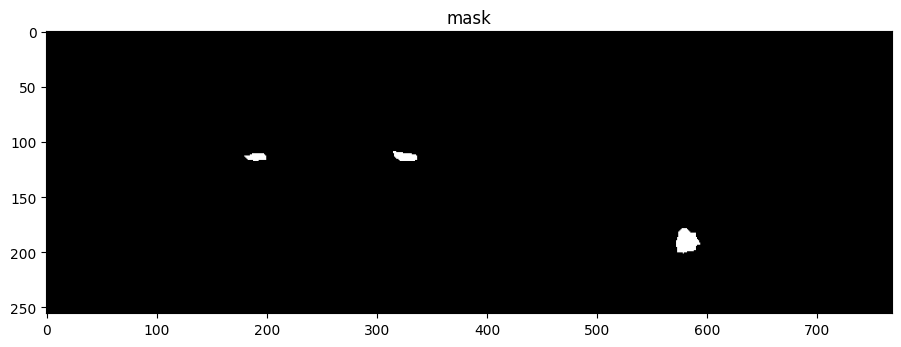

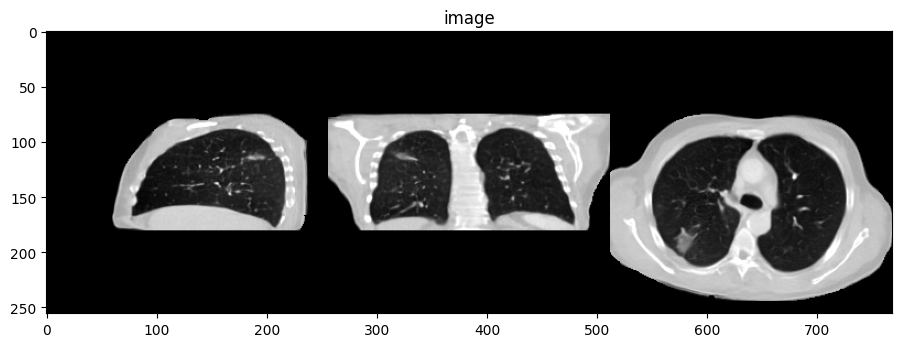

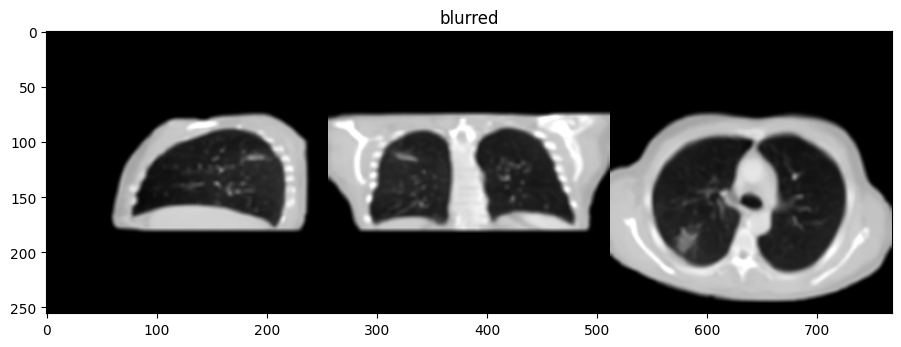

In [6]:
example_image_filename = os.path.join('output', 'sample_20250812_105317_532910_image.nii.gz')
example_mask_filename = os.path.join('output', 'sample_20250812_105317_532910_label.nii.gz')
print(f"Visualizing {example_image_filename} and {example_mask_filename}...")

# load image/mask pairs
loader = LoadImage(image_only=True, ensure_channel_first=True)
orientation = Orientation(axcodes="RAS")
image_volume_original = orientation(loader(example_image_filename))
mask_volume = orientation(loader(example_mask_filename)).to(torch.uint8)

with torch.no_grad():
    image_volume_blurred = subject_model(image_volume_original)

# create a random color map for mask visualization
colorize = torch.clip(torch.cat([torch.zeros(3, 1, 1, 1), torch.ones(3, 200, 1, 1)], 1), 0, 1)
target_class_index = 1

# find center voxel location for 2D slice visualization
center_loc_axis = find_label_center_loc(torch.flip(mask_volume[0, ...] == target_class_index, [-3, -2, -1]))

# visualization
vis_mask = get_xyz_plot(
    mask_volume, center_loc_axis, mask_bool=True, n_label=201, colorize=colorize, target_class_index=target_class_index
)
show_image(vis_mask, title="mask")

# visualize for CT HU intensity between [-200, 500]
image_volume = torch.clip(image_volume_original, -1000, 300)
image_volume = image_volume - torch.min(image_volume)
image_volume = image_volume / torch.max(image_volume)

vis_image = get_xyz_plot(image_volume, center_loc_axis, mask_bool=False)
show_image(vis_image, title="image")

# visualize for CT HU intensity between [-200, 500]
image_volume = torch.clip(image_volume_blurred, -1000, 300)
image_volume = image_volume - torch.min(image_volume)
image_volume = image_volume / torch.max(image_volume)

vis_image = get_xyz_plot(image_volume, center_loc_axis, mask_bool=False)
show_image(vis_image, title="blurred")

In [7]:
def get_mask(ldm_sampler, num_masks):
    """
    Generate multiple synthetic images and masks.

    Args:
        num_masks (int): Number of images to generate.
    """
    modality_tensor = ldm_sampler.modality_tensor
    if len(ldm_sampler.controllable_anatomy_size) > 0:
        # we will use mask generation instead of finding candidate masks
        # create a dummy selected_mask_files for placeholder
        selected_mask_files = list(range(num_masks))
        # prerpare organ size conditions
        anatomy_size_condtion = ldm_sampler.prepare_anatomy_size_condtion(ldm_sampler.controllable_anatomy_size)
    else:
        need_resample = False
        # find candidate mask and save to candidate_mask_files
        candidate_mask_files = find_masks(
            ldm_sampler.body_region,
            ldm_sampler.anatomy_list,
            ldm_sampler.spacing,
            ldm_sampler.output_size,
            True,
            ldm_sampler.all_mask_files_json,
            ldm_sampler.data_root,
        )
        if len(candidate_mask_files) < num_masks:
            # if we cannot find enough masks based on the exact match of anatomy list, spacing, and output size,
            # then we will try to find the closest mask in terms of  spacing, and output size.
            print("Resample mask file to get desired output size and spacing")
            candidate_mask_files = ldm_sampler.find_closest_masks(num_masks)
            need_resample = True

        selected_mask_files = ldm_sampler.select_mask(candidate_mask_files, num_masks)
        if len(selected_mask_files) < num_masks:
            raise ValueError(
                (
                    f"len(selected_mask_files) ({len(selected_mask_files)}) < num_masks ({num_masks}). "
                    "This should not happen. Please revisit function select_mask(ldm_sampler, candidate_mask_files, num_masks)."
                )
            )

    num_generated_img = 0
    for index_s in range(len(selected_mask_files)):
        item = selected_mask_files[index_s]
        if num_generated_img >= num_masks:
            break
        if len(ldm_sampler.controllable_anatomy_size) > 0:
            # generate a synthetic mask
            (
                combine_label_or,
                top_region_index_tensor,
                bottom_region_index_tensor,
                spacing_tensor,
            ) = ldm_sampler.prepare_one_mask_and_meta_info(anatomy_size_condtion)
        else:
            # read in mask file
            mask_file = item["mask_file"]
            if_aug = item["if_aug"]
            (
                combine_label_or,
                top_region_index_tensor,
                bottom_region_index_tensor,
                spacing_tensor,
            ) = ldm_sampler.read_mask_information(mask_file)
            if need_resample:
                combine_label_or = ldm_sampler.ensure_output_size_and_spacing(combine_label_or)
            # mask augmentation
            if if_aug:
                combine_label_or = augmentation(combine_label_or, ldm_sampler.output_size, ldm_sampler.random_seed)
        num_generated_img = num_generated_img + 1
        torch.cuda.empty_cache()
    return (
        combine_label_or.to(device).half(),
        top_region_index_tensor,
        bottom_region_index_tensor,
        spacing_tensor.to(device).half(),
    )

with torch.no_grad():
    (
        combine_label_or,
        top_region_index_tensor,
        bottom_region_index_tensor,
        spacing_tensor,
    ) = get_mask(ldm_sampler, num_masks=1)

Resample mask file to get desired output size and spacing


INFO: Resampling mask to target shape and spacing
INFO: Resize Spacing: [tensor(0.7812, dtype=torch.float64), tensor(0.7812, dtype=torch.float64), tensor(3.0273, dtype=torch.float64)] -> [1.5, 1.5, 4.0]
INFO: Output size: [512, 512, 128] -> [256, 256, 128]
INFO: Resampling mask to target shape and spacing
INFO: Resize Spacing: [tensor(0.7988, dtype=torch.float64), tensor(0.7988, dtype=torch.float64), tensor(1.1016, dtype=torch.float64)] -> [1.5, 1.5, 4.0]
INFO: Output size: [512, 512, 384] -> [256, 256, 128]
INFO: Resampling mask to target shape and spacing
INFO: Resize Spacing: [tensor(0.7031, dtype=torch.float64), tensor(0.7031, dtype=torch.float64), tensor(1.4795, dtype=torch.float64)] -> [1.5, 1.5, 4.0]
INFO: Output size: [512, 512, 256] -> [256, 256, 128]
INFO: Resampling mask to target shape and spacing
INFO: Resize Spacing: [tensor(0.7266, dtype=torch.float64), tensor(0.7266, dtype=torch.float64), tensor(2.5000, dtype=torch.float64)] -> [1.5, 1.5, 4.0]
INFO: Output size: [512, 5

augmenting lung tumor
30
metatensor(7854., device='cuda:0') | metatensor(7704.4004, device='cuda:0')


In [8]:
print(spacing_tensor, args.modality * torch.ones((1,), dtype=torch.long).to(device))

metatensor([[150., 150., 400.]], device='cuda:0', dtype=torch.float16) tensor([1], device='cuda:0')


In [9]:
model = FlowMatchingModel(ldm_sampler)

In [10]:
noise_scheduler = define_instance(args, "noise_scheduler")

NDTM_config = NDTMConfig(N=0, 
                         gamma_t= lambda t: 10 if t < 400 else 0.2 / (t/600), # torch.sigmoid((800 - t)/400) * 20.0, 
                         u_lr=0.002, 
                         w_terminal=2.0, 
                         u_lr_scheduler="linear",
                         w_vf_scheme="zero",
                         w_control_scheme="ones",
                         clip_images=False,
                         pred_each_step=False,
                         noise_scheduler=noise_scheduler,
                        )

In [11]:
ndtm = NDTM(
    generative_model=model,
    subject_model=subject_model,
    hparams=NDTM_config
)

In [12]:
img, _, _ = ndtm.sample(image_volume_original.to(device).half(), 
                        image_volume_blurred.to(device).half(), 
                        num_timesteps=30, 
                        y_0 = image_volume_blurred.to(device).half(),
                        combine_label_tensor=combine_label_or.to(device).half(),
                        top_region_index_tensor=top_region_index_tensor,
                        bottom_region_index_tensor=bottom_region_index_tensor,
                        modality_tensor=args.modality * torch.ones((1,), dtype=torch.long).to(device),
                        spacing_tensor=spacing_tensor.to(device).half(),
                       )

Sampling:   0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████| 605/605 [01:12<00:00,  8.29it/s]


metatensor(0., device='cuda:0', dtype=torch.float16) metatensor(1., device='cuda:0', dtype=torch.float16)
metatensor(0., device='cuda:0', dtype=torch.float16) metatensor(1., device='cuda:0', dtype=torch.float16)


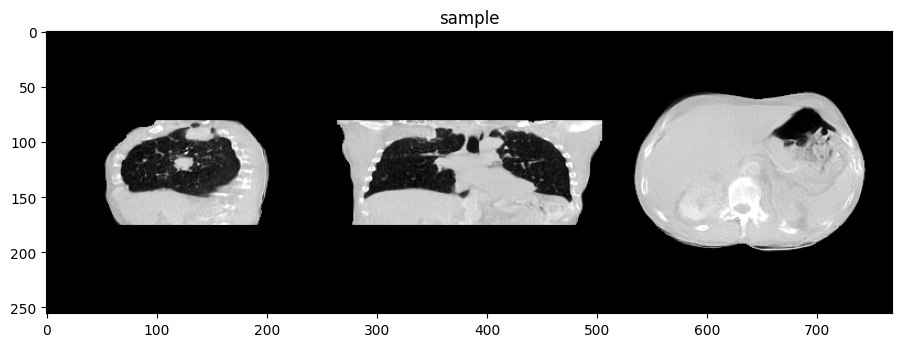

In [35]:
synthetic_labels = model.get_label_tensor(combine_label_tensor=combine_label_or.to(device).half())
print(torch.min(synthetic_labels), torch.max(synthetic_labels))
synthetic_labels[synthetic_labels != 1] = 0
print(torch.min(synthetic_labels), torch.max(synthetic_labels))
center_loc_axis = find_label_center_loc(torch.flip(synthetic_labels[0, 0, ...] == target_class_index, [-3, -2, -1]))


image_volume = torch.clip(img, -1000, 300)
image_volume = image_volume - torch.min(image_volume)
image_volume = image_volume / torch.max(image_volume)

vis_image = get_xyz_plot(image_volume, center_loc_axis, mask_bool=False)
show_image(vis_image, title="sample")

In [31]:
center_loc_axis[1:]

[metatensor(0, device='cuda:0'),
 metatensor(105, device='cuda:0'),
 metatensor(122, device='cuda:0'),
 metatensor(95, device='cuda:0')]

In [19]:
(synthetic_labels - combine_label_or.to(device).half()).sum()

metatensor(-inf, device='cuda:0', dtype=torch.float16)

In [21]:
torch.min(synthetic_labels), torch.max(synthetic_labels)

(metatensor(0, device='cuda:0'), metatensor(0, device='cuda:0'))

In [22]:
torch.min(combine_label_or), torch.max(combine_label_or)

(metatensor(0., device='cuda:0', dtype=torch.float16),
 metatensor(200., device='cuda:0', dtype=torch.float16))

In [24]:
mask_volume = orientation(loader("./output/sample_20250815_145833_439193_label.nii.gz")).to(torch.uint8)
torch.min(mask_volume), torch.max(mask_volume)

(metatensor(0, dtype=torch.uint8), metatensor(1, dtype=torch.uint8))

In [33]:
output_filenames = ldm_sampler.sample_multiple_images(args.num_output_samples)

INFO: Resample mask file to get desired output size and spacing
INFO: Resampling mask to target shape and spacing
INFO: Resize Spacing: [tensor(0.7812, dtype=torch.float64), tensor(0.7812, dtype=torch.float64), tensor(3.0273, dtype=torch.float64)] -> [1.5, 1.5, 4.0]
INFO: Output size: [512, 512, 128] -> [256, 256, 128]
INFO: Resampling mask to target shape and spacing
INFO: Resize Spacing: [tensor(0.7988, dtype=torch.float64), tensor(0.7988, dtype=torch.float64), tensor(1.1016, dtype=torch.float64)] -> [1.5, 1.5, 4.0]
INFO: Output size: [512, 512, 384] -> [256, 256, 128]
INFO: Resampling mask to target shape and spacing
INFO: Resize Spacing: [tensor(0.7031, dtype=torch.float64), tensor(0.7031, dtype=torch.float64), tensor(1.4795, dtype=torch.float64)] -> [1.5, 1.5, 4.0]
INFO: Output size: [512, 512, 256] -> [256, 256, 128]
INFO: Resampling mask to target shape and spacing
INFO: Resize Spacing: [tensor(0.7266, dtype=torch.float64), tensor(0.7266, dtype=torch.float64), tensor(2.5000, dty

augmenting lung tumor
32
metatensor(0., device='cuda:0') | metatensor(1351.5000, device='cuda:0')
metatensor(981., device='cuda:0') | metatensor(1351.5000, device='cuda:0')
metatensor(0., device='cuda:0') | metatensor(1351.5000, device='cuda:0')
metatensor(0., device='cuda:0') | metatensor(1351.5000, device='cuda:0')
metatensor(368., device='cuda:0') | metatensor(1351.5000, device='cuda:0')
metatensor(4., device='cuda:0') | metatensor(1351.5000, device='cuda:0')
metatensor(0., device='cuda:0') | metatensor(1351.5000, device='cuda:0')
metatensor(369., device='cuda:0') | metatensor(1351.5000, device='cuda:0')
metatensor(0., device='cuda:0') | metatensor(1351.5000, device='cuda:0')
metatensor(742., device='cuda:0') | metatensor(1351.5000, device='cuda:0')
metatensor(0., device='cuda:0') | metatensor(1351.5000, device='cuda:0')
metatensor(0., device='cuda:0') | metatensor(1351.5000, device='cuda:0')
metatensor(0., device='cuda:0') | metatensor(1351.5000, device='cuda:0')
metatensor(0., dev

INFO: ---- Mask preparation time: 4.761446714401245 seconds ----
INFO: ---- Start generating latent features... ----


metatensor(1790., device='cuda:0') | metatensor(1351.5000, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 11.25it/s]
INFO: ---- DM/ControlNet Latent features generation time: 2.6752469539642334 seconds ----
INFO: ---- Start decoding latent features into images... ----
100%|██████████████████████████████████████████████████████████████████| 605/605 [01:16<00:00,  7.87it/s]
INFO: ---- Image VAE decoding time: 76.92586064338684 seconds ----


1 5
2025-08-15 16:25:34,527 INFO image_writer.py:197 - writing: output/sample_20250815_162534_520367_image.nii.gz
2025-08-15 16:25:35,017 INFO image_writer.py:197 - writing: output/sample_20250815_162534_520367_label.nii.gz


[metatensor(191), metatensor(175), metatensor(58)]


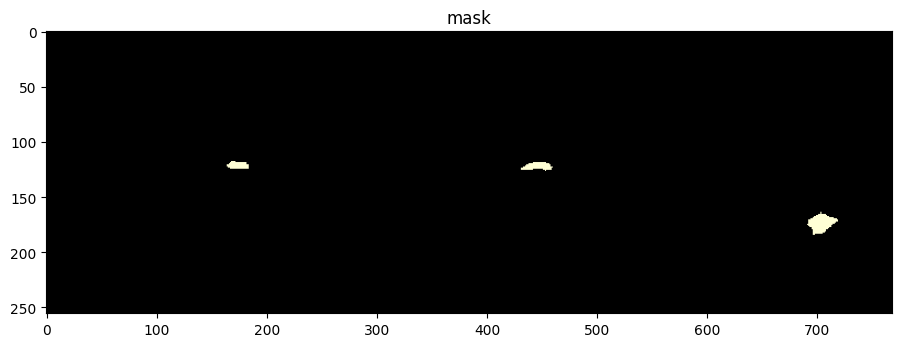

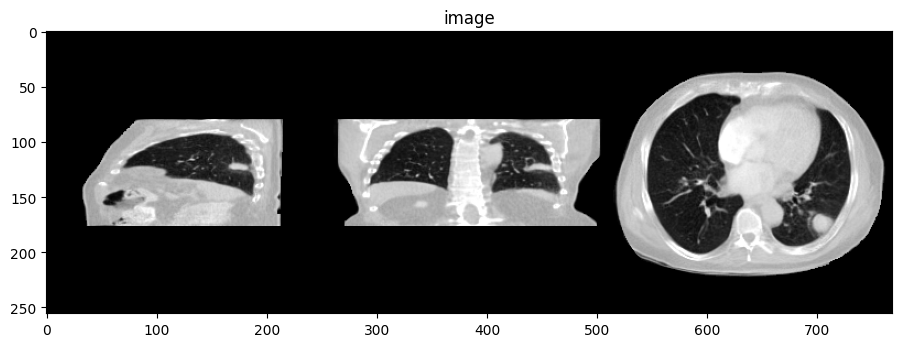

In [34]:
visualize_image_filename = output_filenames[0][0]
visualize_mask_filename = output_filenames[0][1]

# load image/mask pairs
loader = LoadImage(image_only=True, ensure_channel_first=True)
orientation = Orientation(axcodes="RAS")
image_volume = orientation(loader(visualize_image_filename))
mask_volume = orientation(loader(visualize_mask_filename)).to(torch.uint8)

# visualize for CT HU intensity between [-200, 500]
image_volume = torch.clip(image_volume, -1000, 300)
image_volume = image_volume - torch.min(image_volume)
image_volume = image_volume / torch.max(image_volume)

# create a random color map for mask visualization
colorize = torch.clip(torch.cat([torch.zeros(3, 1, 1, 1), torch.randn(3, 200, 1, 1)], 1), 0, 1)
target_class_index = 1

# find center voxel location for 2D slice visualization
center_loc_axis = find_label_center_loc(torch.flip(mask_volume[0, ...] == target_class_index, [-3, -2, -1]))
print(center_loc_axis)
# visualization
vis_mask = get_xyz_plot(
    mask_volume, center_loc_axis, mask_bool=True, n_label=201, colorize=colorize, target_class_index=target_class_index
)
show_image(vis_mask, title="mask")

vis_image = get_xyz_plot(image_volume, center_loc_axis, mask_bool=False)
show_image(vis_image, title="image")

In [13]:
noise_scheduler.set_timesteps(
    num_inference_steps=30,
    input_img_size_numel=torch.prod(torch.tensor(latent_shape[2:])),
)
noise_scheduler.timesteps

tensor([1000.0000,  920.0000,  847.5000,  781.5000,  720.5000,  665.0000,
         613.5000,  566.0000,  522.0000,  480.7500,  442.5000,  406.7500,
         373.2500,  341.7500,  312.0000,  284.0000,  257.7500,  232.8750,
         209.2500,  186.8750,  165.6250,  145.3750,  126.1250,  107.7500,
          90.2500,   73.5625,   57.5312,   42.2188,   27.5625,   13.5000],
       dtype=torch.float16)